In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy.stats import spearmanr, mannwhitneyu, ks_2samp

sns.set_theme(style="whitegrid", font_scale=1.1)

sys.path.append("../EDA")
DATA_PATH = "../instruction/movieReplicationSet.csv"
ALPHA = 0.005

import movie_data_formatter as mdf
import movie_rating_gender as mrgy
import general_functions as gf

df = pd.read_csv(DATA_PATH)
df = mdf.clean_data(df)
processed_data = mdf.convert_to_table(df).dropna(subset=['rating'])


In [50]:
# emotional engagement items (Likert 1–5)
emotion_items = mdf.get_movie_experience_names(df)
emotion_items = [mdf.clean_column_name(item) for item in emotion_items]


# compute emotional engagement index (mean of 10 items per viewer)
emotion_scores = (
    processed_data[['report_id'] + emotion_items]
    .drop_duplicates(subset='report_id')
    .set_index('report_id')
)
emotion_scores['emotion_mean'] = emotion_scores[emotion_items].mean(axis=1)

# compute variance in ratings per viewer (rating variability)
rating_var = (
    processed_data.groupby('report_id')['rating']
    .var()
    .rename('rating_var')
)

# merge emotion scores and rating variability
viewer_data = pd.concat([emotion_scores['emotion_mean'], rating_var], axis=1).dropna()

# spearman correlation test
rho, pval = spearmanr(viewer_data['emotion_mean'], viewer_data['rating_var'])
print(f"Spearman correlation: rho={rho:.3f}, p={pval:.3e}")

# Mann–Whitney U test (median split)
median_emotion = viewer_data['emotion_mean'].median()
low = viewer_data.loc[viewer_data['emotion_mean'] <= median_emotion, 'rating_var']
high = viewer_data.loc[viewer_data['emotion_mean'] > median_emotion, 'rating_var']

U, p = mannwhitneyu(low, high, alternative='two-sided')

# ks test 
statistic, p_value = ks_2samp(low, high)
print(f"Kolmogorov-Smirnov test: statistic={statistic:.3f}, p={p_value:.3e}")

print(f"Mann–Whitney U test: U={U:.2f}, p={p:.3e}")
print(f"Mean variability (low): {low.mean():.3f}, Mean variability (high): {high.mean():.3f}")



Spearman correlation: rho=-0.014, p=6.385e-01
Kolmogorov-Smirnov test: statistic=0.045, p=6.337e-01
Mann–Whitney U test: U=142685.50, p=5.612e-01
Mean variability (low): 0.761, Mean variability (high): 0.776


/var/folders/9t/kz_xx0px1mxf1wqtzvvb57fc0000gn/T/ipykernel_83908/3129010087.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=bx, x="group", y="rating_var", palette=["0.7", "0.3"], ax=axes[0])


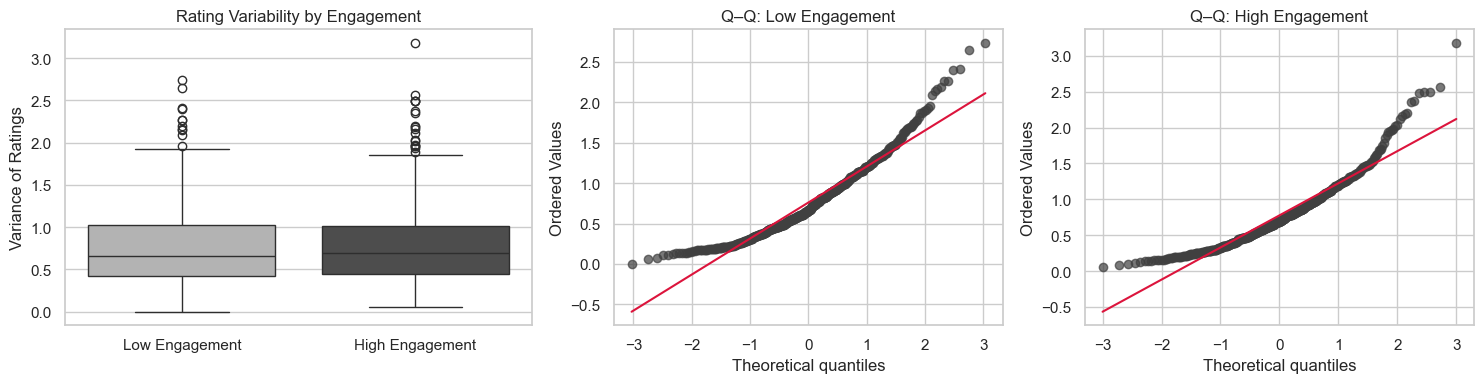

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

bx = pd.DataFrame({
    "group": (["Low Engagement"] * len(low)) + (["High Engagement"] * len(high)),
    "rating_var": pd.concat([low, high], ignore_index=True)
}).dropna()

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={"width_ratios": [1.2, 1, 1]})

sns.boxplot(data=bx, x="group", y="rating_var", palette=["0.7", "0.3"], ax=axes[0])
axes[0].set_title("Rating Variability by Engagement")
axes[0].set_xlabel("")
axes[0].set_ylabel("Variance of Ratings")

stats.probplot(low.dropna(),  dist="norm", plot=axes[1])
axes[1].set_title("Q–Q: Low Engagement")
stats.probplot(high.dropna(), dist="norm", plot=axes[2])
axes[2].set_title("Q–Q: High Engagement")

for ax in axes[1:]:
    line = ax.get_lines()[1]; line.set_color("crimson")
    pts  = ax.get_lines()[0]; pts.set_markerfacecolor("0.25"); pts.set_markeredgecolor("0.25"); pts.set_alpha(0.7)

plt.tight_layout()
plt.savefig("../figures/rating_variability_box_qq.pdf", dpi=300)
plt.show()
